---
title: "Open Stablecoin Index"
format: 
  html:
    code-tools: false
execute:
  enabled: false
  echo: false
---

In [41]:
from pathlib import Path
rootdir = Path.cwd()
import polars as pl


open_transfer_df = pl.read_parquet(rootdir/'data/open_transfers_decoded.parquet')
blocks_df = pl.read_parquet(rootdir / 'data/blocks.parquet')


# blocks_df.write_parquet('data/blocks.parquet')
open_transfer_df = open_transfer_df.join(
    blocks_df.select(['block_number', 'block_timestamp', 'block_datetime', 'block_date']), 
    left_on='block_number', 
    right_on='block_number',
    how='left'
)

# open_transfer_df.select([
#     'transaction_hash', 'block_number', 'address', 'from_address', 'to_address', 'amount', 'block_date', 'block_datetime'
# ])

## Total Supply

In [42]:
# Create complete date range from min to max date in the data
min_date = open_transfer_df['block_date'].min()
max_date = open_transfer_df['block_date'].max()
ZERO_ADDRESS = '0x0000000000000000000000000000000000000000'

# Generate all dates in the range
all_dates_df = pl.DataFrame({
    'block_date': pl.date_range(min_date, max_date, interval='1d', eager=True)
})

# Aggregate mints by date
mints_daily = (
    open_transfer_df
    .filter(pl.col('from_address') == ZERO_ADDRESS)
    .group_by('block_date')
    .agg(pl.col('amount').sum().alias('minted'))
)

# Aggregate burns by date
burns_daily = (
    open_transfer_df
    .filter(pl.col('to_address') == ZERO_ADDRESS)
    .group_by('block_date')
    .agg(pl.col('amount').sum().alias('burned'))
)

# Join all dates with mints and burns, filling missing values with 0
mints_daily = (
    all_dates_df
    .join(mints_daily, on='block_date', how='left')
    .with_columns(pl.col('minted').fill_null(0))
    .sort('block_date')
)

burns_daily = (
    all_dates_df
    .join(burns_daily, on='block_date', how='left')
    .with_columns(pl.col('burned').fill_null(0))
    .sort('block_date')
)

# Combine and calculate cumulative supply
supply_over_time = (
    all_dates_df
    .join(mints_daily, on='block_date', how='left')
    .join(burns_daily, on='block_date', how='left')
    .with_columns([
        pl.col('minted').fill_null(0),
        pl.col('burned').fill_null(0)
    ])
    .with_columns([
        (pl.col('minted') - pl.col('burned')).alias('net_change'),
        (pl.col('minted') - pl.col('burned')).cum_sum().alias('total_supply')
    ])
    .sort('block_date')
)

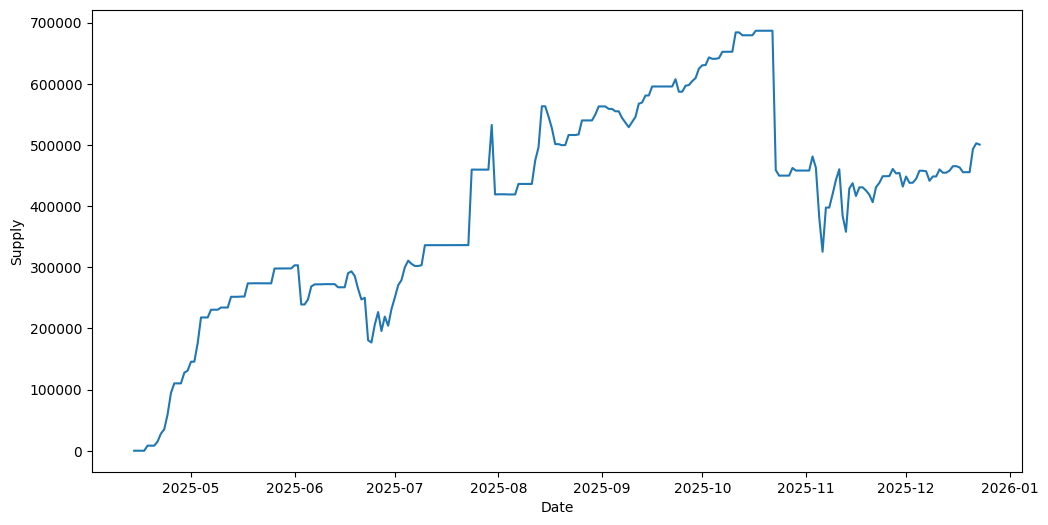

In [43]:
import matplotlib.pyplot as plt

# Plot total supply over time
# Cast UInt128 columns to Float64 for pandas compatibility
data = supply_over_time.with_columns([
    pl.col('minted').cast(pl.Float64),
    pl.col('burned').cast(pl.Float64),
    pl.col('net_change').cast(pl.Float64),
    pl.col('total_supply').cast(pl.Float64)
]).to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(data['block_date'], data['total_supply'], label='Total Supply')
plt.xlabel('Date')
plt.ylabel('Supply');

## Number of Holders

In [44]:
# Sort transfers by block number and log index to ensure chronological order
transfers_sorted = open_transfer_df.sort(['block_number', 'log_index'])

# Create a list to track balance changes for each address
# We'll create two dataframes: one for outgoing (from) and one for incoming (to)
outgoing = transfers_sorted.select([
    'block_date',
    'from_address',
    pl.col('amount').alias('amount_change')
]).rename({'from_address': 'address'}).with_columns(
    pl.col('amount_change') * -1  # Negative for outgoing
)

incoming = transfers_sorted.select([
    'block_date', 
    'to_address',
    pl.col('amount').alias('amount_change')
]).rename({'to_address': 'address'})

# Combine all balance changes
all_changes = pl.concat([outgoing, incoming])

# Filter out zero address (mints/burns don't count as holders)
all_changes = all_changes.filter(pl.col('address') != ZERO_ADDRESS)

# Get all unique addresses
all_addresses = all_changes.select('address').unique()

# Create a complete grid of all dates × all addresses
address_date_grid = all_addresses.join(all_dates_df, how='cross')

# Calculate daily changes per address
daily_changes = (
    all_changes
    .group_by(['address', 'block_date'])
    .agg(pl.col('amount_change').sum().alias('daily_change'))
)

# Join the complete grid with actual daily changes, filling missing with 0
balances_by_date = (
    address_date_grid
    .join(daily_changes, on=['address', 'block_date'], how='left')
    .with_columns([
        pl.col('daily_change').fill_null(0)
    ])
    .sort(['address', 'block_date'])
    .with_columns([
        pl.col('daily_change')
        .cum_sum()
        .over('address')
        .alias('balance')
    ])
)

balances_by_date

# For each date, count how many addresses have balance > 0
holders_by_date = (
    balances_by_date
    .filter(pl.col('balance') > 0)
    .group_by('block_date')
    .agg(pl.col('address').n_unique().alias('num_holders'))
    .sort('block_date')
)

# Fill in missing dates with forward fill (holders persist until they sell)
holders_over_time = (
    all_dates_df
    .join(holders_by_date, on='block_date', how='left')
    .with_columns([
        pl.col('num_holders').fill_null(strategy='forward').fill_null(0)
    ])
    .sort('block_date')
)

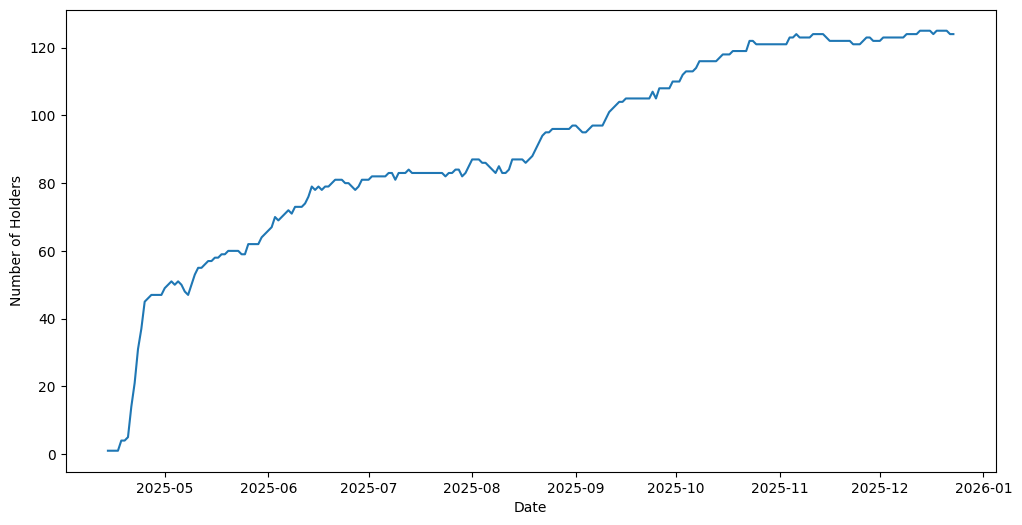

In [ ]:
data = holders_over_time
plt.figure(figsize=(12, 6))
plt.plot(data['block_date'], data['num_holders'], label='Number of Holders')
plt.xlabel('Date')
plt.ylabel('Number of Holders');

# Liquidity

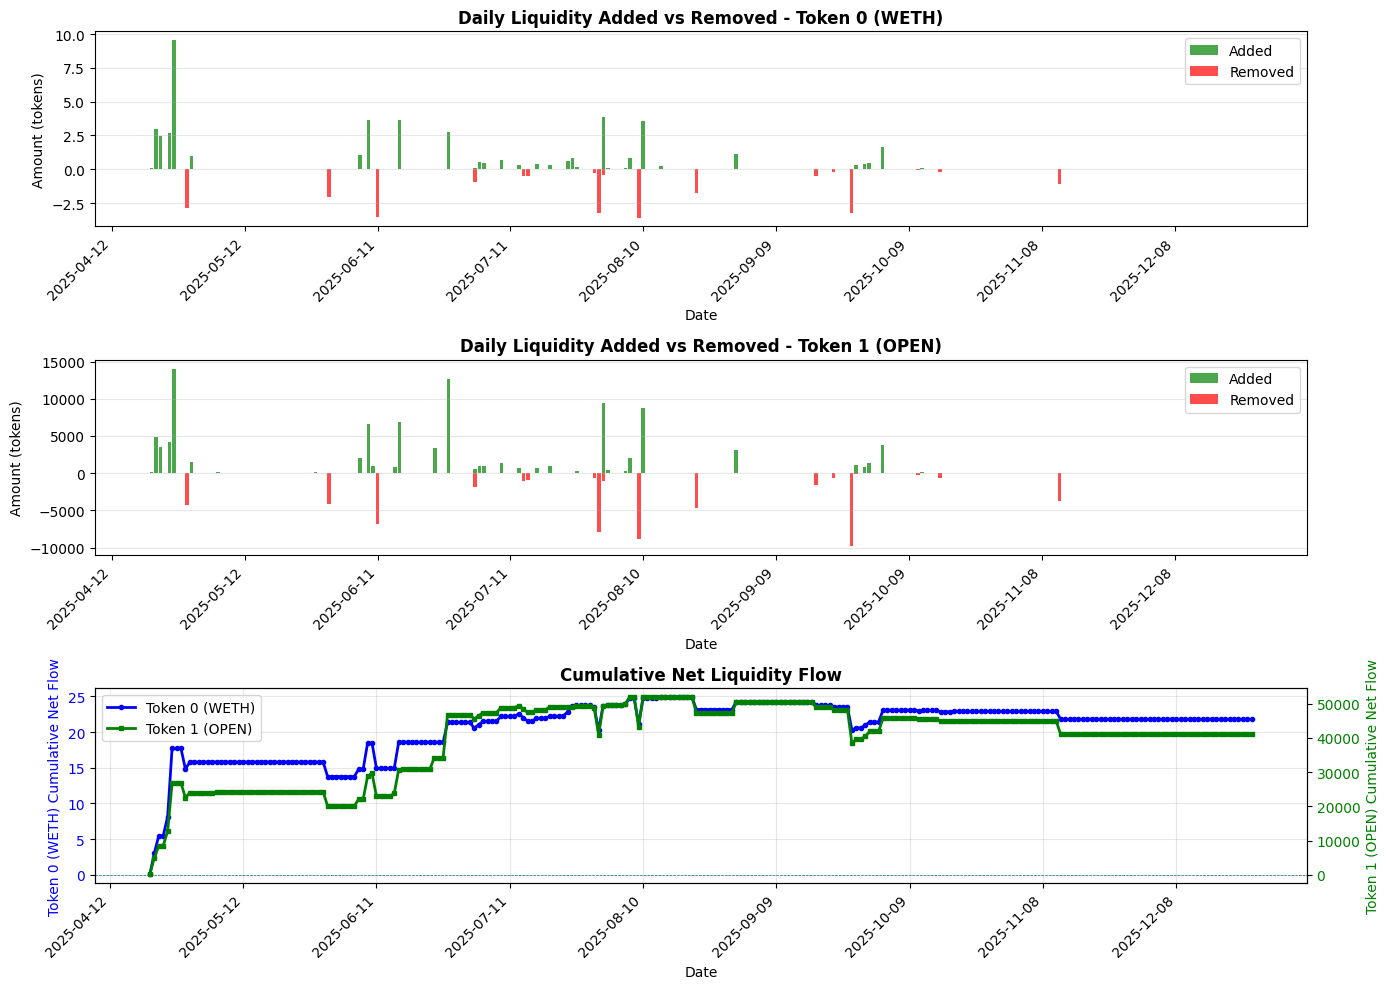

In [45]:
# Add vs Remove comparison chart
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
daily_net_flow_pd = pd.read_parquet('data/daily_net_flow.parquet')

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Token 0 - Bar chart with dates on x-axis
ax1 = axes[0]
ax1.bar(daily_net_flow_pd['block_date'], daily_net_flow_pd['daily_added_token_0'], 
        label='Added', color='green', alpha=0.7)
ax1.bar(daily_net_flow_pd['block_date'], daily_net_flow_pd['daily_removed_token_0'], 
        label='Removed', color='red', alpha=0.7, bottom=0)
ax1.set_title('Daily Liquidity Added vs Removed - Token 0 (WETH)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Amount (tokens)')
ax1.set_xlabel('Date')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to ~10 labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Token 1 - Bar chart with dates on x-axis
ax2 = axes[1]
ax2.bar(daily_net_flow_pd['block_date'], daily_net_flow_pd['daily_added_token_1'], 
        label='Added', color='green', alpha=0.7)
ax2.bar(daily_net_flow_pd['block_date'], daily_net_flow_pd['daily_removed_token_1'], 
        label='Removed', color='red', alpha=0.7, bottom=0)
ax2.set_title('Daily Liquidity Added vs Removed - Token 1 (OPEN)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Amount (tokens)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to ~10 labels
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax3 = axes[2]
# Create twin axis for token 1
ax3_twin = ax3.twinx()

# Plot token 0 on left y-axis
ax3.plot(daily_net_flow_pd['block_date'], daily_net_flow_pd['cumulative_net_token_0'],
         marker='o', label='Token 0 (WETH)', color='blue', linewidth=2, markersize=3)
ax3.axhline(y=0, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot token 1 on right y-axis
ax3_twin.plot(daily_net_flow_pd['block_date'], daily_net_flow_pd['cumulative_net_token_1'],
              marker='s', label='Token 1 (OPEN)', color='green', linewidth=2, markersize=3)
ax3_twin.axhline(y=0, color='green', linestyle='--', linewidth=0.5, alpha=0.5)

# Set labels and formatting
ax3.set_title('Cumulative Net Liquidity Flow', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Token 0 (WETH) Cumulative Net Flow', color='blue')
ax3_twin.set_ylabel('Token 1 (OPEN) Cumulative Net Flow', color='green')
ax3.tick_params(axis='y', labelcolor='blue')
ax3_twin.tick_params(axis='y', labelcolor='green')
ax3.grid(True, alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax3.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to ~10 labels
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()